<a href="https://colab.research.google.com/github/d-passaro/pySeifert/blob/main/qft_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install torchdiffeq --quiet
from torchdiffeq import odeint

In [ ]:
DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
elif hasattr(torch, 'has_mps') and torch.backends.mps.is_available():
  DEVICE = torch.device('mps')

Partially based on [2101.08176]

# Prior distribution

In [ ]:
class SimpleNormal:
  def __init__(self, loc, var):
    self.dist = torch.distributions.normal.Normal(
      torch.flatten(loc), torch.flatten(var))
    self.shape = loc.shape
  def log_prob(self, x):
    logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
    return torch.sum(logp, dim=1)
  def sample_n(self, batch_size):
    x = self.dist.sample((batch_size,))
    return x.reshape(batch_size, *self.shape)

# Theory action

In [ ]:
class ScalarPhi4Action:
  def __init__(self, M2, lam):
    self.M2 = M2
    self.lam = lam
  def __call__(self, cfgs):
    # potential term
    action_density = self.M2*cfgs**2 + self.lam*cfgs**4
    # kinetic term (discrete Laplacian)
    Nd = len(cfgs.shape)-1
    dims = range(1,Nd+1)
    for mu in dims:
      action_density += 2*cfgs**2
      action_density -= cfgs*torch.roll(cfgs, -1, mu)
      action_density -= cfgs*torch.roll(cfgs, 1, mu)
    return torch.sum(action_density, dim=tuple(dims))

# Network architecture

In [ ]:
from torch import nn


def linear_kernel(val, pos, width):
  val = 1 - torch.abs(val - pos) / width
  return torch.maximum(val, torch.tensor(0.))


class CNF(nn.Module):
  def __init__(self, lattice_size=5, n_freq=10, n_time=5):
    super().__init__()

    self.shape = (lattice_size, lattice_size)
    
    assert lattice_size % 2 == 1, 'lattice size must be odd for padding to work.'
    self.conv = nn.Conv2d(n_freq, n_time, lattice_size, padding_mode='circular', padding=lattice_size//2)
    self.conv.weight = torch.nn.Parameter(torch.zeros_like(self.conv.weight))

    self.register_parameter(name='freq', param=torch.nn.Parameter(5 * torch.randn(n_freq)))
    
    self.pos = torch.linspace(0, 1, n_time)
    self.width = 1 / (n_time - 1)
    
    self.prior = SimpleNormal(torch.zeros(*self.shape), torch.tensor(1.))
      

  def forward(self, t, phi_logp):
    phi, logp = phi_logp
    freq = self.get_parameter('freq').reshape(1, -1, 1, 1)
    freq_features = torch.sin(phi.reshape(-1, 1, *self.shape) * freq)
    time_features = self.conv(freq_features)
    time_kernel = linear_kernel(t, self.pos, self.width)
    grad = torch.einsum('bt...,t->b...', time_features, time_kernel)
    
    weight_0 = self.conv.weight[:, :, self.shape[0]//2, self.shape[1]//2]
    freq_features_grad = freq * torch.cos(phi.reshape(-1, 1, *self.shape) * freq)
    grad_logp = - torch.einsum('tf,bfxy,t->b', weight_0, freq_features_grad, time_kernel)
    return grad, grad_logp
  
  
  def sample(self, batch_size):
    x = self.prior.sample_n(batch_size)
    logp = self.prior.log_prob(x)
    (_, phi), (_, logp) = odeint(self, (x, logp), torch.tensor([0., 1.]), method='rk4', options=dict(step_size=1/30))
    return phi, logp

# Plotting during training

In [ ]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
  fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
  plt.xlim(0, N_era*N_epoch)
  plt.ylim(0, 1)
  
  ess_line = plt.plot([0],[0], alpha=0.5) # dummy
  plt.grid(False)
  plt.ylabel('ESS')
  
  ax_loss = ax_ess.twinx()
  loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
  plt.grid(False)
  plt.ylabel('Loss')
  
  plt.xlabel('Epoch')

  display_id = display(fig, display_id=True)

  return dict(
    fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
    ess_line=ess_line, loss_line=loss_line,
    display_id=display_id
  )

def moving_average(x, window=10):
  if len(x) < window:
    return np.mean(x, keepdims=True)
  else:
    return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
  Y = np.array(history['ess'])
  Y = moving_average(Y, window=15)
  ess_line[0].set_ydata(Y)
  ess_line[0].set_xdata(np.arange(len(Y)))
  Y = history['loss']
  Y = moving_average(Y, window=15)
  loss_line[0].set_ydata(np.array(Y))
  loss_line[0].set_xdata(np.arange(len(Y)))
  ax_loss.relim()
  ax_loss.autoscale_view()
  fig.canvas.draw()
  display_id.update(fig)

# Training 

## setup

In [ ]:
L = 5
action = ScalarPhi4Action(-4, 8.0)
model = CNF(L, 5, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(.85, .9))

## loss & training step

In [ ]:
def calc_dkl(logp, logq):
  return (logq - logp).mean()

In [ ]:
def train_step(model, optimizer, metrics):
  optimizer.zero_grad()

  x, logq = model.sample(batch_size)
  logp = -action(x)
  loss = calc_dkl(logp, logq)
  loss.backward()

  optimizer.step()

  metrics['loss'].append(loss.detach().cpu().numpy())
  metrics['ess'].append(compute_ess(logp, logq).detach().cpu().numpy())

In [ ]:
def compute_ess(logp, logq):
  logw = logp - logq
  log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
  ess_per_cfg = torch.exp(log_ess) / len(logw)
  return ess_per_cfg

## run training

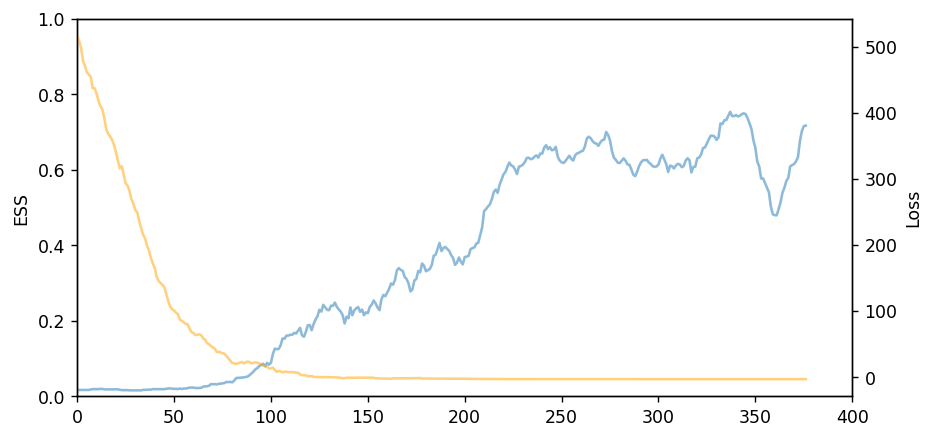

In [ ]:
N_era = 4
N_epoch = 100
batch_size = 64
plot_freq = 10

history = {
  'loss' : [],
  'ess' : []
}

[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
live_plot = init_live_plot()

for era in range(N_era):
  for epoch in range(N_epoch):
    train_step(model, optimizer, history)

    if epoch % plot_freq == 0:
      update_plots(history, **live_plot)

plt.close('all')

## look at examples

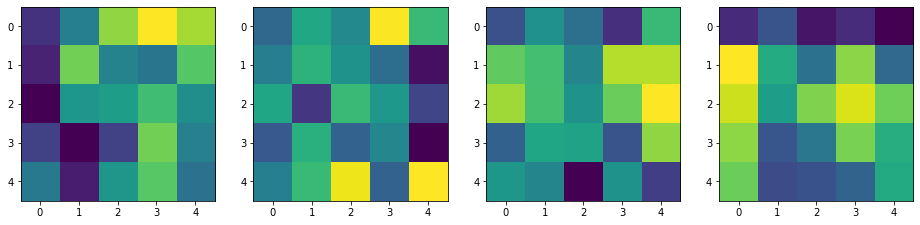

In [ ]:
plt.figure(figsize=(16, 4))

phis, _ = model.sample(4)
for i in range(4):
  plt.subplot(141 + i)
  plt.imshow(phis[i].cpu().detach().numpy())